In [65]:
import pandas as pd
import json
import os

files = os.listdir("results_delta_2025-06-28")

json_files = {}
for file in files:
    with open("results_delta_2025-06-28/"+file, "r") as f:
        df = pd.DataFrame(json.load(f))
        json_files[file] = df

df = pd.concat(json_files.values(), axis = 0)
df

,tensor_location,criterion_score,layer_name,value_before,value_after
0,"[0, 0, 0]",0.7608,class_token,-0.000680,0.000320
0,"[0, 0, 0, 0]",0.7608,conv_proj.weight,-0.000241,0.000759
0,[0],0.7608,conv_proj.bias,-0.002264,-0.001264
0,"[0, 0, 0]",0.7608,encoder.pos_embedding,-0.000680,0.000320
0,[0],0.7608,encoder.layers.encoder_layer_0.ln_1.weight,-0.000631,0.000369
...,...,...,...,...,...
0,[0],0.7608,encoder.layers.encoder_layer_11.mlp.3.bias,-0.000661,-0.000651
0,[0],0.7608,encoder.ln.weight,0.533204,0.533214
0,[0],0.7608,encoder.ln.bias,-0.011042,-0.011032
0,"[0, 0]",0.7608,heads.head.weight,0.049962,0.049972


In [66]:
df.dtypes

tensor_location     object
criterion_score    float64
layer_name          object
value_before       float64
value_after        float64
dtype: object

In [67]:
from math import log10, floor
def round_to_1(x):
    return round(x, -int(floor(log10(abs(x)))))

df['tensor_location'] = df['tensor_location'].astype(str).astype('|S') # which will by default set the length to the max len it encounters
df['layer_name'] = df['layer_name'].astype('|S') # which will by default set the length to the max len it encounters
df['delta_val'] = (df['value_after'] - df["value_before"]).apply(round_to_1)
df['delta'] = df['delta_val'].astype('|S')
df.dtypes

tensor_location       |S12
criterion_score    float64
layer_name            |S62
value_before       float64
value_after        float64
delta_val          float64
delta                 |S32
dtype: object

In [68]:
df = df.sort_values(by = ["layer_name", "delta", "tensor_location", "criterion_score"]).reset_index(drop = True)
df

,tensor_location,criterion_score,layer_name,value_before,value_after,delta_val,delta
0,"b'[0, 0, 0]'",0.7608,b'class_token',-0.000680,0.000320,0.00100,b'0.001'
1,"b'[0, 0, 0]'",0.7602,b'class_token',-0.000680,0.099320,0.10000,b'0.1'
2,"b'[0, 0, 0]'",0.0940,b'class_token',-0.000680,0.999320,1.00000,b'1.0'
3,"b'[0, 0, 0]'",0.1068,b'class_token',-0.000680,9.999320,10.00000,b'10.0'
4,"b'[0, 0, 0]'",0.0272,b'class_token',-0.000680,99.999321,100.00000,b'100.0'
...,...,...,...,...,...,...,...
1059,"b'[0, 0]'",0.7606,b'heads.head.weight',0.049962,1.049962,1.00000,b'1.0'
1060,"b'[0, 0]'",0.7202,b'heads.head.weight',0.049962,10.049962,10.00000,b'10.0'
1061,"b'[0, 0]'",0.4202,b'heads.head.weight',0.049962,100.049965,100.00000,b'100.0'
1062,"b'[0, 0]'",0.3784,b'heads.head.weight',0.049962,1000.049988,1000.00000,b'1000.0'


<Axes: xlabel='delta', ylabel='criterion_score'>

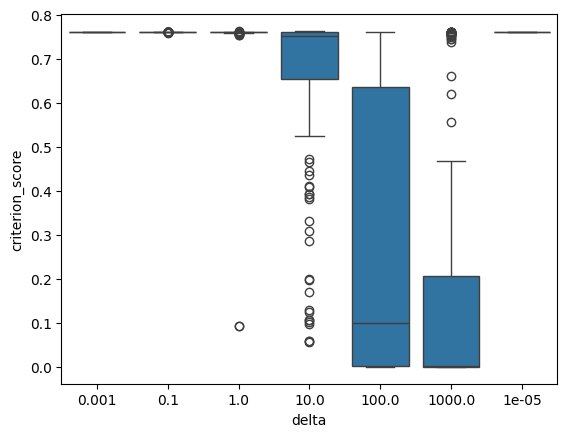

In [69]:
import seaborn as sns

sns.boxplot(data = df, x = "delta", y = "criterion_score")

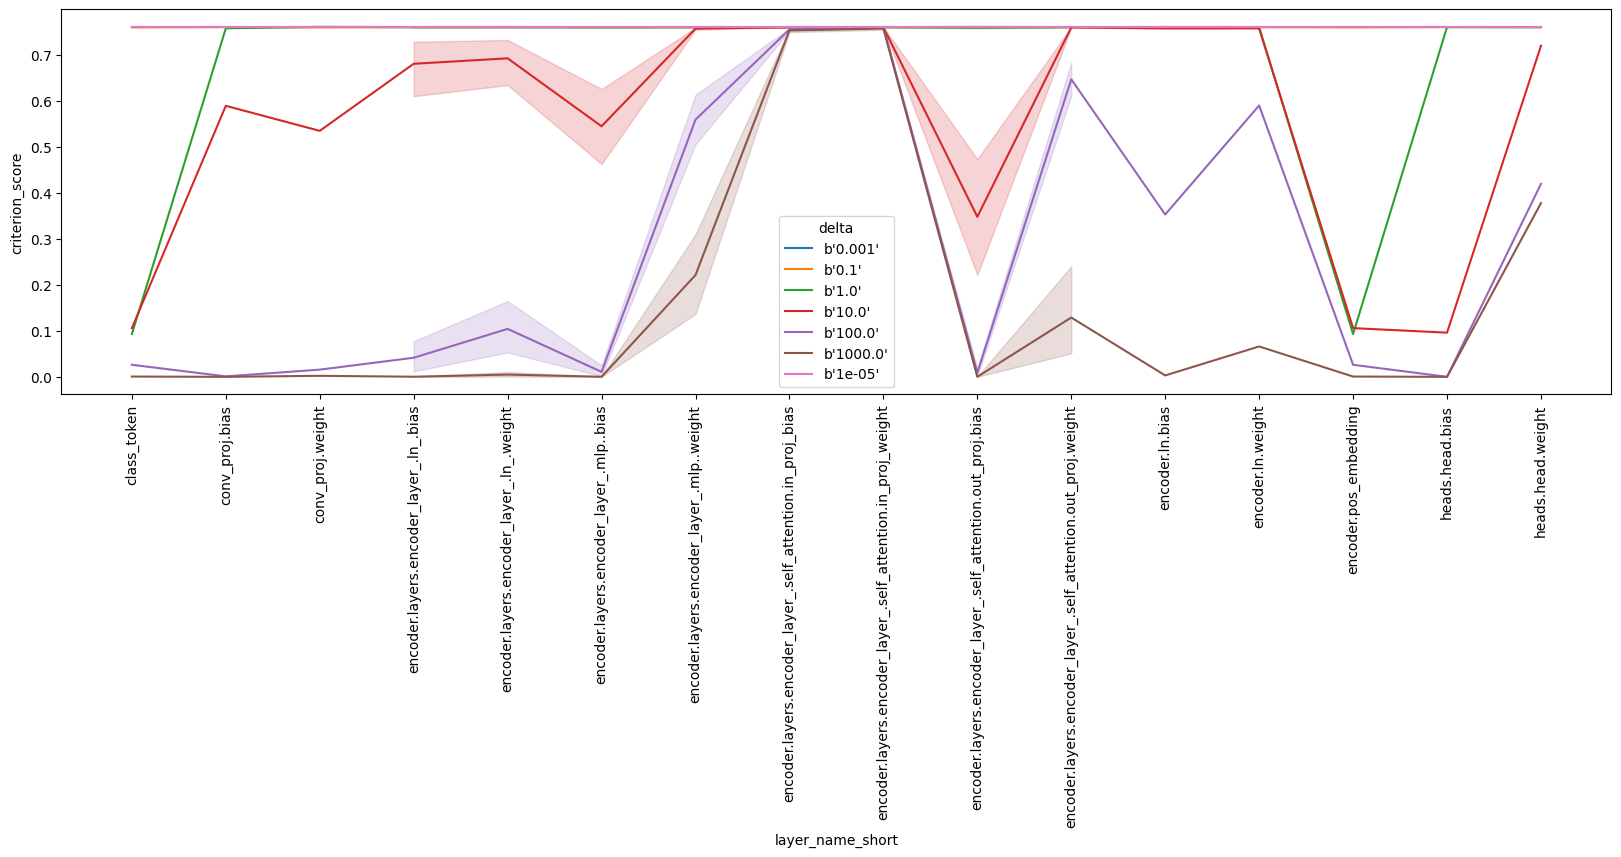

In [70]:
import matplotlib.pyplot as plt

df["layer_name_short"] = df["layer_name"].apply(lambda x: x.decode() if isinstance(x, bytes) else x).str.replace(r'\d+', '', regex=True)


plt.figure(figsize=(20,5))
sns.lineplot(data = df, x = "layer_name_short", y = "criterion_score", hue = "delta")
plt.xticks(rotation = 90)
plt.show()

In [71]:
df["delta"].value_counts()

C:\Users\wwden\AppData\Local\Temp\ipykernel_6020\857499797.py:1: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  df["delta"].value_counts()


delta
b'0.001'     152
b'0.1'       152
b'1.0'       152
b'10.0'      152
b'100.0'     152
b'1000.0'    152
b'1e-05'     152
Name: count, dtype: int64

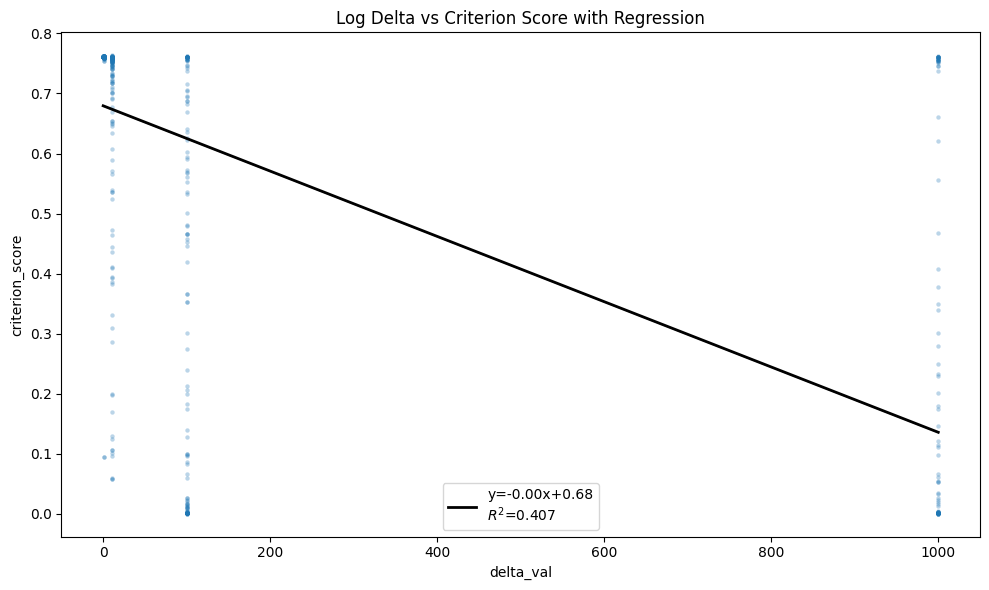

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Precompute regression
X = df["delta_val"].values.reshape(-1, 1)
y = df["criterion_score"].values
reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)
r2 = r2_score(y, y_pred)
slope = reg.coef_[0]
intercept = reg.intercept_

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="delta_val", y="criterion_score", alpha=0.3, s=10, linewidth=0)

# Overlay regression line
sns.lineplot(x=df["delta_val"], y=y_pred, color='black', linewidth=2, label=f"y={slope:.2f}x+{intercept:.2f}\n$R^2$={r2:.3f}")

plt.title("Log Delta vs Criterion Score with Regression")
plt.legend()
plt.tight_layout()
plt.show()


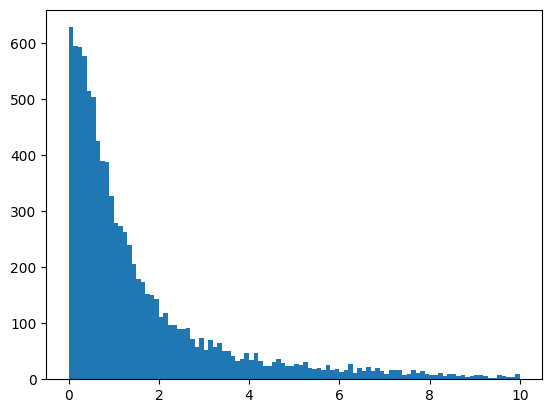

In [73]:
import numpy as np
import matplotlib.pyplot as plt

data = np.abs(np.random.standard_cauchy(10000))
data = data[data < 10]  # filter out extreme values

plt.hist(data, bins=100)
# plt.xscale("log")
plt.show()
